In [1]:
from estimador import *
from filtros import *
from fit_voc import *
from functions import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

### Obtenemos los datos para parametrizar el modelo de la batería

In [2]:
# Obtenemos el ground truth
path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/git_repositories/degradation_model/uncertainty_characterization/stanford_cell_SOH.csv"
SOH_gt_df = pd.read_csv(path,delimiter=';',)
SOH_gt_df = SOH_gt_df.drop(index=0).reset_index(drop=True)

path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))

SOH_gt_df["files"] = files
SOH_gt_df

,W3,W4,W5,W7,W8,W9,W10,G1,V4,V5,files
0,0.991165,0.995239,0.995041,0.990868,0.991326,0.991863,0.993366,0.986739,0.991591,0.996553,C1.csv
1,0.981574,0.984155,0.984068,0.977048,0.978800,0.978999,0.979203,0.973698,0.984149,0.980047,C2.csv
2,0.000000,0.964448,0.972587,0.966905,0.969747,0.968954,0.966177,0.963144,0.976851,0.968160,C3.csv
3,0.000000,0.953926,0.953046,0.000000,0.953927,0.955331,0.954701,0.959798,0.969108,0.000000,C4.csv
4,0.000000,0.958505,0.947708,0.000000,0.951501,0.952444,0.952462,0.958529,0.964674,0.000000,C5.csv
5,0.000000,0.944989,0.940969,0.000000,0.942567,0.943475,0.943691,0.955073,0.960795,0.000000,C6.csv
6,0.000000,0.940327,0.934069,0.000000,0.934454,0.935122,0.935875,0.950352,0.955500,0.000000,C7.csv
7,0.000000,0.000000,0.936182,0.000000,0.929295,0.932702,0.933866,0.947226,0.950634,0.000000,C8.csv
8,0.000000,0.000000,0.933865,0.000000,0.930129,0.932778,0.933686,0.943072,0.947881,0.000000,C9.csv
9,0.000000,0.000000,0.930750,0.000000,0.928541,0.930311,0.930635,0.938144,0.945301,0.000000,C10.csv


In [3]:
EQ_cycles = []
subcycles = [   25,
                50,
                47,
                22,
                1,
                1,
                4,
                29,
                37,
                25,
                25,
                25,
                25,
                25]
SR_0 = 100
SR = 80
acc_subc = 0
for idx,subcycle in enumerate(subcycles):
    eq_cycle = subcycle*(SR/SR_0)
    acc_subc += eq_cycle
    EOL_0 = SOH_gt_df["W9"].values[idx]
    eta_0 = EOL_0**(1/acc_subc)
    eq_cycle08 = 1/log_a(0.8,eta_0)
    EQ_cycles.append(eq_cycle08)

SOH_gt_df["eq_cycles08_W9"] = EQ_cycles

### Definimos los modelos a usar

In [4]:
param = dict(
    vL=1.35531394,
    v0=4.12017677,
    gamma=0.13286143,
    alpha=0.16945463,
    beta=2.34538224,
    Qmax=4.850,
    Bias_Rint=0.01454392,
    Factor_Rint=0.1879029,
    life_cycles=SOH_gt_df["eq_cycles08_W9"].values[-1],
    adapt_cell=True,
    degradation_percentage=0.8
)

f_new = FiltrosAnidados_new()
f_new.Q_inst = param.get("Qmax")
f_new.fit_batt_model(param)
f_new.modelo_th.fit_inverse()
f_new.voc_thresh = 0.05
f_new.voc_times = 47
f_new.sigma_autonomia = 0.04
f_new.sigma_capacidad = 0.001 * 5
f_new.estim_kwargs = {"sigma_e": 0.00075}

f_aramis = FiltrosAnidados_aramis()
f_aramis.Q_inst = param.get("Qmax")
f_aramis.fit_batt_model(param)
f_aramis.modelo_th.fit_inverse()
f_aramis.voc_thresh = 0.05
f_aramis.voc_times = 47
f_aramis.sigma_autonomia = 0.04
f_aramis.sigma_capacidad = 0.001 * 5
f_aramis.estim_kwargs = {"sigma_e": 0.00075}

f_adap = FiltrosAnidados_aramis()
f_adap.Q_inst = param.get("Qmax")
f_adap.fit_batt_model(param)
f_adap.modelo_th.fit_inverse()
f_adap.voc_thresh = 0.05
f_adap.voc_times = 47
f_adap.sigma_autonomia = 0.04
f_adap.sigma_capacidad = 0.001 * 5
f_adap.estim_kwargs = {"sigma_e": 0.00075}

if f_adap.modelo_th.parameters["adapt_cell"]:
    f_adap.modelo_th.adapt_degradation()
    f_adap.modelo_th.setup_knn()
    print("celda: f_adap adaptada")

modelo de celda seteado. Tabla de degradación:  {'100-0': [1.0], '100-25': [0.7875], '75-0': [1.12525], '100-50': [0.4375], '75-25': [0.6875], '50-0': [1.03125], '100-75': [0.40625], '75-50': [0.297], '62.5-37.5': [0.28125], '50-25': [0.625], '25-0': [1.0]}
Parámetros del modelo:
{'A_Rint': 0.3084,
 'B_Rint': -0.2578,
 'Bias_Rint': 0.01454392,
 'C_Rint': -0.05083,
 'D_Rint': 0.1317,
 'Factor_R_SOH0': 0.28371948548,
 'Factor_R_SOH1': -0.57276721458,
 'Factor_R_SOH2': 0.32037195027000004,
 'Factor_R_SOH3': 0.02140399288,
 'Factor_Rint': 0.1879029,
 'Qmax': 4.85,
 'adapt_cell': True,
 'alpha': 0.16945463,
 'beta': 2.34538224,
 'degradation_data': {'100-0': [1.0],
                      '100-25': [0.7875],
                      '100-50': [0.4375],
                      '100-75': [0.40625],
                      '25-0': [1.0],
                      '50-0': [1.03125],
                      '50-25': [0.625],
                      '62.5-37.5': [0.28125],
                      '75-0': [1.12525],

### Ejecutamos el modelo de degradación

In [5]:
file_path = os.path.join(path, "C1.csv")
columns_to_select = ["step_ind","SoC"]
df = pd.read_csv(file_path,usecols=columns_to_select)

## Actualizamos la capacidad máxima de cada modelo
f_aramis.Q_inst = param.get("Qmax")
f_adap.Q_inst = param.get("Qmax")
f_new.Q_inst = param.get("Qmax")

## Iniciamos las configuraciones para el proceso de filtrado
path = os.path.join('C:/Users/Bruno/Dropbox','Dataset Stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))
files.remove('C7.csv')
print(files)

## Iniciamos las variables del modelo
## Variables globales
cycles = []
Q_healthy = param.get("Qmax")

## Variables método eq_cycle adap
dsoc_adap = 0
soc_acc_adap = 0
soc_inst_eqcycle_adap = df.SoC.values[0]*100
soc_counting_eqcycle_adap = [soc_inst_eqcycle_adap]  # Initialize soc_counting list
step_counting_eqcycle_adap = [df.step_ind.values[0]]  # Initialize soc_counting list
eqcycle_SoH_values_adap = []

## Variables método eq_cycle new
dsoc_new = 0
soc_acc_new = 0
soc_inst_eqcycle_new = df.SoC.values[0]*100
soc_counting_eqcycle_new = [soc_inst_eqcycle_new]  # Initialize soc_counting list
step_counting_eqcycle_new = [df.step_ind.values[0]]  # Initialize soc_counting list
eqcycle_SoH_values_new = []

## Variables método eq_cycle new
dsoc_aramis = 0
soc_acc_aramis = 0
soc_inst_eqcycle_aramis = df.SoC.values[0]*100
soc_counting_eqcycle_aramis = [soc_inst_eqcycle_aramis]  # Initialize soc_counting list
step_counting_eqcycle_aramis = [df.step_ind.values[0]]  # Initialize soc_counting list
eqcycle_SoH_values_aramis = []

## Variables GT
gt_idx = 0
gt_soh_values = [1]  # Initialize knn_SoH_values list
gt_soh_idx = [gt_idx]

# Iterating through all the datasets
for file in files:
    if not file.endswith(".csv"):
        continue  # Skip files that are not CSV

    file_path = os.path.join(path, file)
    columns_to_select = ["step_ind","current","time","exp"]
    df = pd.read_csv(file_path,usecols=columns_to_select)

    gt_soh_value = SOH_gt_df["W10"].values[files.index(file)]
    gt_soh_values.append(gt_soh_value)
    gt_idx += round(len(df.current.values)/100)
    gt_soh_idx.append(gt_idx)

    for cnt, exp in enumerate(df.exp.unique()):
        print(file, cnt, end="\r")
        df_ = df[df.exp == exp]

        # Iterate over the rows in the filtered DataFrame
        for ind, (c, dt, step,step_) in enumerate(zip(df_.current.values,
                                                    df_.time.values[1:] - df_.time.values[:-1],
                                                    df_.step_ind.values,
                                                    df_.step_ind.values[1:])):
            # hacemos conteo de coulomb
            dsoc_aramis = dt * c / (f_aramis.Q_inst * 36)
            dsoc_adap = dt * c / (f_adap.Q_inst * 36)
            dsoc_new = dt * c / (f_new.Q_inst * 36)

            # actualizamos el soc
            soc_inst_eqcycle_aramis += dsoc_aramis
            soc_inst_eqcycle_adap += dsoc_adap
            soc_inst_eqcycle_new += dsoc_new

            if soc_inst_eqcycle_aramis >= 100:
                soc_inst_eqcycle_aramis = 100
            elif soc_inst_eqcycle_aramis < 0:
                soc_inst_eqcycle_aramis = 0

            if soc_inst_eqcycle_adap >= 100:
                soc_inst_eqcycle_adap = 100
            elif soc_inst_eqcycle_adap < 0:
                soc_inst_eqcycle_adaps = 0

            if soc_inst_eqcycle_new >= 100:
                soc_inst_eqcycle_new = 100
            elif soc_inst_eqcycle_new < 0:
                soc_inst_eqcycle_new = 0
            
            ## implementación metodo eqcycle
        
            if dsoc_aramis < 0:
                soc_acc_aramis += dsoc_aramis
                soc_counting_eqcycle_aramis.append(soc_inst_eqcycle_aramis)
            if -100 >= soc_acc_aramis:
                eta_k_eqcycle_aramis = f_aramis.get_factor(soc_counting_eqcycle_aramis,unnml=False)
                f_aramis.Q_inst *= eta_k_eqcycle_aramis[0]
                soc_acc_aramis = 0
                soc_counting_eqcycle_aramis = []
            
            if dsoc_adap < 0:
                soc_acc_adap += dsoc_adap
                soc_counting_eqcycle_adap.append(soc_inst_eqcycle_adap)
            if -100 >= soc_acc_adap:
                eta_k_eqcycle_adap = f_adap.get_factor(soc_counting_eqcycle_adap,unnml=False)
                f_adap.Q_inst *= eta_k_eqcycle_adap[0]
                soc_acc_adap = 0
                soc_counting_eqcycle_adap = []

            if dsoc_new < 0:
                soc_acc_new += dsoc_new
                soc_counting_eqcycle_new.append(soc_inst_eqcycle_new)
            if -100 >= soc_acc_new:
                eta_k_eqcycle_new = f_new.get_factor(soc_counting_eqcycle_new,25)
                f_new.Q_inst *= eta_k_eqcycle_new[0]
                soc_acc_new = 0
                soc_counting_eqcycle_new = []

            # actualización de SoH por método
            eqcycle_SoH_values_aramis.append(f_aramis.Q_inst / Q_healthy)
            eqcycle_SoH_values_adap.append(f_adap.Q_inst / Q_healthy)
            eqcycle_SoH_values_new.append(f_new.Q_inst / Q_healthy)

['C1.csv', 'C2.csv', 'C3.csv', 'C4.csv', 'C5.csv', 'C6.csv', 'C8.csv', 'C9.csv', 'C10.csv', 'C11.csv', 'C12.csv', 'C13.csv', 'C14.csv']


### Graficamos los resultados

In [6]:
# lineal = lineal_SoH_values[::100]
# aramis = eqcycle_SoH_values_aramis[::100]
aramis = eqcycle_SoH_values_aramis[::100]
adap = eqcycle_SoH_values_adap[::100]
new = eqcycle_SoH_values_new[::100]
# lineal = eqcycle_SoH_values_lineal[::100]
# subcnom = subcnom_SoH_values[::100]
# subc = subc_SoH_values[::100]



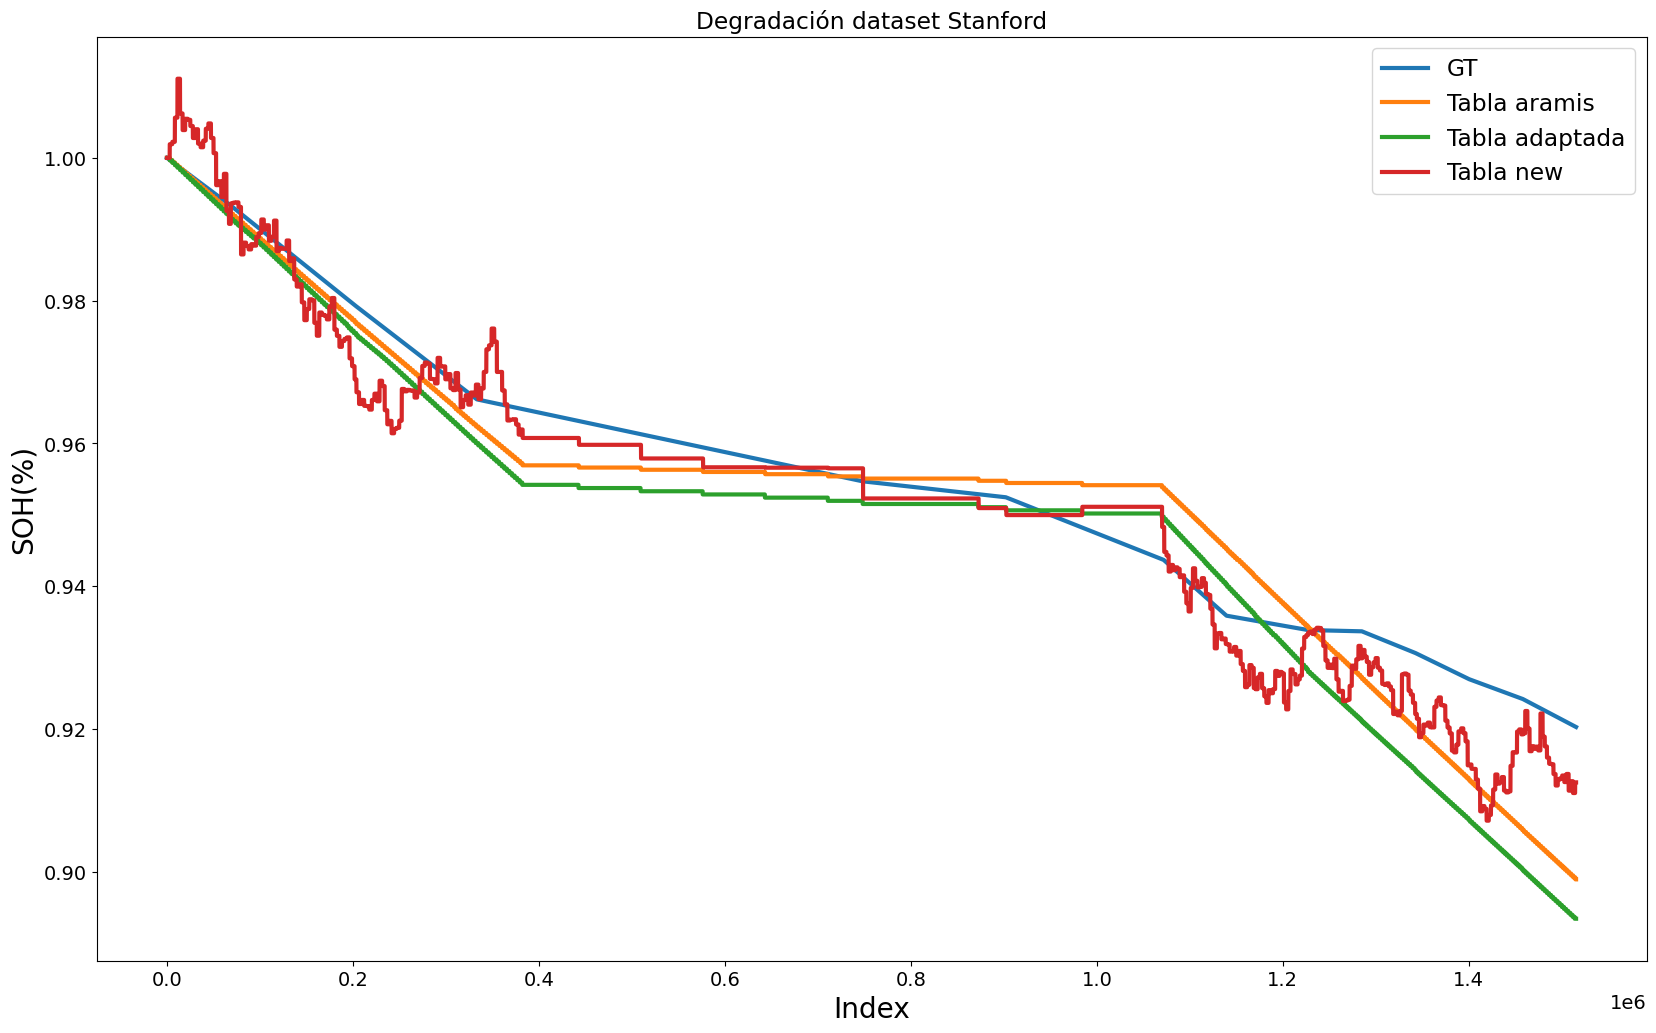

In [7]:
plt.figure(figsize=(20, 12))

plt.plot(gt_soh_idx,gt_soh_values, label="GT")
plt.plot(aramis, label='Tabla aramis')
plt.plot(adap, label='Tabla adaptada')
plt.plot(new, label='Tabla new')

plt.title("Degradación dataset Stanford")
plt.xlabel("Index")
plt.ylabel("SOH(%)")
plt.legend()
plt.show()

In [8]:
error = gt_soh_values[-1] - adap[-1]
np.round(error*100,2)

2.69

### Guardamos los resultados del experimento

In [9]:
filename = 'adap_discharge_profile.csv'
data = adap
# Writing to a CSV file
with open(filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for item in data:
        csvwriter.writerow([item])

print(f"Data saved to {filename}")

Data saved to adap_discharge_profile.csv


### Importamos los datos para comparar

In [10]:
filename = 'adap_discharge_profile.csv'
# Leer el archivo CSV
with open(filename, newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    adap_discharge_profile = [float(row[0]) for row in csvreader]
filename = 'adap_full_profile.csv'
# Leer el archivo CSV
with open(filename, newline='') as csvfile:
    csvreader = csv.reader(csvfile)
    adap_full_profile = [float(row[0]) for row in csvreader]

FileNotFoundError: [Errno 2] No such file or directory: 'adap_full_profile.csv'

In [ ]:
adap[32000]

0.9969435218494279

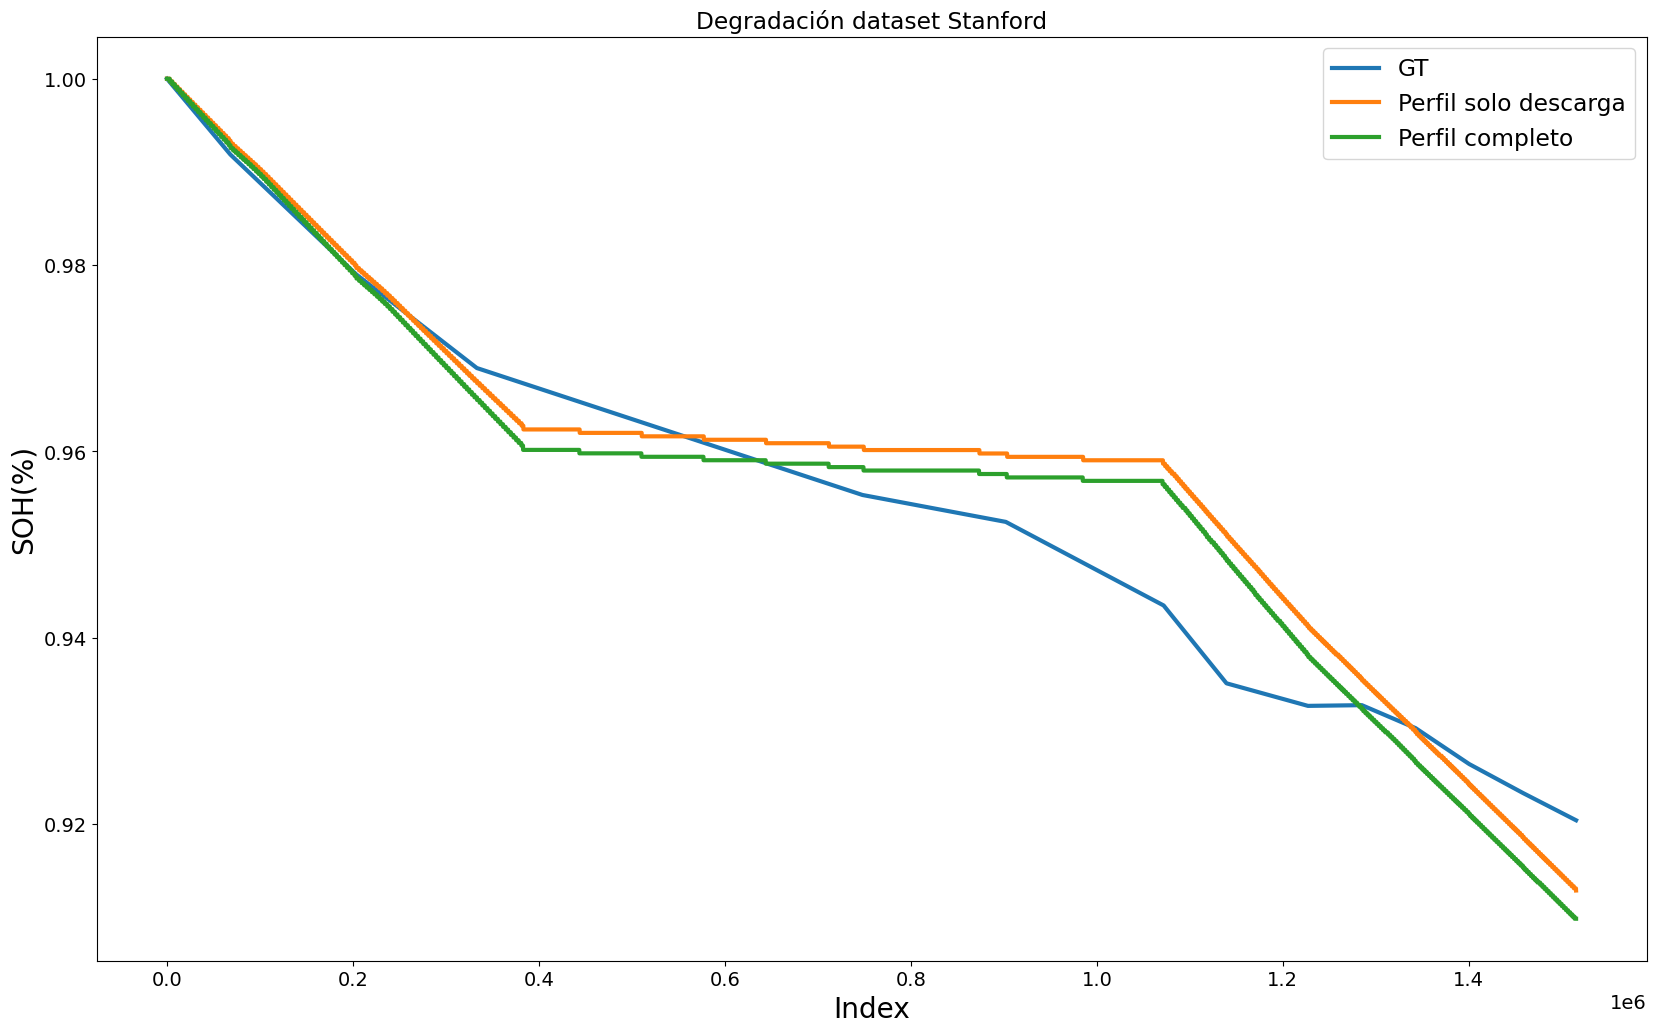

In [ ]:
plt.figure(figsize=(20, 12))

plt.plot(gt_soh_idx,gt_soh_values, label="GT")
# plt.plot(lineal, label='Metodo lineal')
# plt.plot(maxmin, label='Metodo maxmin')
# plt.plot(aramis, label='Tabla original Aramis')
plt.plot(adap_discharge_profile, label='Perfil solo descarga')
plt.plot(adap_full_profile, label='Perfil completo')
# plt.plot(lineal, label='Tabla lineal')
# plt.plot(subc, label='Actualización por subciclo')

plt.title("Degradación dataset Stanford")
plt.xlabel("Index")
plt.ylabel("SOH(%)")
plt.legend()
plt.show()

### Sacamos el error por cada diagnóstico